In [2]:
import os
import torch
from torch import nn
import dltools

In [28]:
def read_imdb(data_dir,is_train):
    data,labels = [],[]
    for label in ('pos','neg'):
        floder_name = os.path.join(data_dir,'train' if is_train else 'test',label)
        for file in os.listdir(floder_name):
            with open(os.path.join(floder_name,file),'rb') as f:
                review = f.read().decode('utf-8').replace('\n','')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data,labels


In [8]:
data_dir = r"D:\ai\hello_nlp\data\aclImdb_v1\aclImdb"
train_data = read_imdb(data_dir,True)


In [9]:
train_tokens = dltools.tokenize(train_data[0],token='word')

In [17]:
len(train_tokens)

25000

In [10]:
vocaab = dltools.Vocab(train_tokens,min_freq=5,reserved_tokens=['<pad>'])

In [11]:
len(vocaab)

49347

(array([   0.,   12.,   37.,  128.,  376.,  483.,  449.,  486.,  464.,
         491.,  748., 1313., 1734., 1609., 1416., 1214., 1070.,  948.,
         852.,  750.,  650.,  612.,  539.,  524.,  492.,  426.,  418.,
         344.,  337.,  323.,  327.,  285.,  278.,  249.,  241.,  251.,
         225.,  209.,  157.,  163.,  171.,  158.,  161.,  151.,  118.,
         131.,  128.,  120.,  116.,   86.,  102.,   87.,   92.,   79.,
          77.,   77.,   72.,   63.,   74.,   63.,   55.,   62.,   51.,
          51.,   38.,   43.,   42.,   43.,   47.,   32.,   43.,   37.,
          32.,   36.,   26.,   33.,   29.,   20.,   26.,   25.,   28.,
          28.,   23.,   24.,   13.,   22.,   13.,   17.,   15.,   18.,
          17.,   18.,   10.,   15.,   14.,   14.,   26.,   29.,   26.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 3

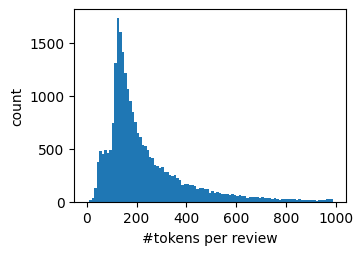

In [15]:
dltools.set_figsize()
dltools.plt.xlabel('#tokens per review')
dltools.plt.ylabel('count')
dltools.plt.hist([len(line) for line in train_tokens], bins = range(0,1000,10))

In [18]:
num_step = 500
train_features = torch.tensor([dltools.truncate_pad(vocaab[line],num_step,vocaab['<pad>']) for line in train_tokens])

In [21]:
train_iter = dltools.load_array((train_features ,torch.tensor(train_data[1])),64,True)

In [23]:
for X, y in train_iter:
    print('X:',X.shape,'y:',y.shape)
    break
print('小批次数量:',len(train_iter))

X: torch.Size([64, 500]) y: torch.Size([64])
小批次数量: 391


In [30]:
def loda_data_imdb(data_dir,batch_size,num_step=500):
    train_data = read_imdb(data_dir=data_dir,is_train=True)
    test_data = read_imdb(data_dir=data_dir,is_train=False)
    train_tokens = dltools.tokenize(train_data[0],token='word')
    test_tokens = dltools.tokenize(test_data[0],token='word')
    vocaab = dltools.Vocab(train_tokens,min_freq=5,reserved_tokens=['<pad>'])
    train_features = torch.tensor([dltools.truncate_pad(vocaab[line],num_step,vocaab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([dltools.truncate_pad(vocaab[line],num_step,vocaab['<pad>']) for line in test_tokens])
    train_iter = dltools.load_array((train_features ,torch.tensor(train_data[1])),batch_size,True)
    test_iter = dltools.load_array((test_features ,torch.tensor(test_data[1])),batch_size,True)
    return train_iter,test_iter,vocaab


In [42]:
data_dir = r"D:\ai\hello_nlp\data\aclImdb_v1\aclImdb"
train_iter,test_iter,vocab = loda_data_imdb(data_dir,64)

In [32]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size,embed_size,num_hiddens,num_layers, **kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.encoder = nn.LSTM(embed_size,num_hiddens,num_layers,bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self,inputs):
        embedding = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embedding)
        encodding = torch.cat((outputs[0],outputs[-1]),dim=1)
        outs = self.decoder(encodding)
        return outs

In [33]:
class TokenEmbedding:
    def __init__(self, file_path):
        self.idx_to_token,self.idx_to_vec = self._loda_embedding(file_path)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    def _loda_embedding(self,file_path):
        idx_to_token,idx_to_vec = ['<unk>'],[]
        with open(file_path,'r',encoding='utf-8') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token,elems = elems[0] ,[float(elem) for elem in elems[1:]]
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec=[[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec) 
    def __getitem__(self,tokens):
        indices = [self.token_to_idx.get(token,self.unknown_idx) for token in tokens]
        vecs  = self.idx_to_vec[torch.tensor(indices)]
        return vecs
    
    def __len__(self):
        return len(self.idx_to_token)

In [44]:
embed_size,num_hiddens,num_lalyers = 100,100,2
devices = dltools.try_all_gpus()
net = BiRNN(len(vocaab),embed_size,num_hiddens,num_lalyers)

In [38]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if 'weight' in param:
                nn.init.xavier_uniform_(m._parameters[param])


net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49347, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [39]:
glove_embedding = TokenEmbedding(r'D:/ai/hello_nlp\data/glove.6B/glove.6B.100d.txt')

In [40]:
embeds = glove_embedding[vocaab.idx_to_token]

In [41]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.008, train acc 0.997, test acc 0.801
1989.7 examples/sec on [device(type='cuda', index=0)]


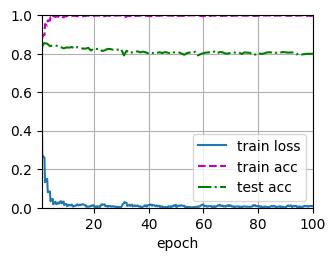

In [46]:
lr,num_epochs = 0.01,100
trainer = torch.optim.Adam(net.parameters(),lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
dltools.train_ch13(net,train_iter,test_iter,loss,trainer,num_epochs,devices)